In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import os
import random
import shutil

# ===== 1. SOURCE PATHS =====
src_fundus_yes = "/content/drive/MyDrive/final_dataset_for_flutter/train/Yes"
src_fundus_no  = "/content/drive/MyDrive/final_dataset_for_flutter/train/No"
src_lungs_normal = "/content/drive/MyDrive/final_dataset_for_flutter/NORMAL"
src_bone_fractured     = "/content/drive/MyDrive/final_dataset_for_flutter/BoneFractureDataset/training/fractured"
src_bone_not_fractured = "/content/drive/MyDrive/final_dataset_for_flutter/BoneFractureDataset/training/not_fractured"
src_brain_mri = "/content/drive/MyDrive/final_dataset_for_flutter/pituitary"

# ===== 2. DESTINATION ROOT =====
dest_root = "/content/medical_dataset"

# ===== 3. PARAMETERS =====
train_count = 500
val_count   = 50
test_count  = 100
total_needed = train_count + val_count + test_count

# ===== 4. DELETE OLD DATASET IF EXISTS =====
if os.path.exists(dest_root):
    shutil.rmtree(dest_root)
    print(f"🗑️ Deleted existing folder: {dest_root}")

# ===== 5. COUNT IMAGES =====
def count_images(src_dirs):
    total = 0
    for d in src_dirs:
        total += len([f for f in os.listdir(d) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return total

classes = {
    "fundus": [src_fundus_yes, src_fundus_no],
    "chest_xray": [src_lungs_normal],
    "bone_fracture": [src_bone_fractured, src_bone_not_fractured],
    "brain_mri": [src_brain_mri]
}

all_ok = True
for cls, paths in classes.items():
    count = count_images(paths)
    print(f"📊 {cls}: {count} images")
    if count < total_needed:
        print(f"❌ Not enough images for {cls}! Need at least {total_needed}.")
        all_ok = False

# ===== 6. CREATE DATASET IF ALL OK =====
if all_ok:
    print("✅ All classes have enough images. Creating dataset...")

    def copy_images(src_dirs, dest_class_name):
        # Merge images from multiple dirs
        all_images = []
        for d in src_dirs:
            files = [os.path.join(d, f) for f in os.listdir(d) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            all_images.extend(files)

        random.shuffle(all_images)
        selected = all_images[:total_needed]

        # Split into train, val, test
        train_split = selected[:train_count]
        val_split   = selected[train_count:train_count+val_count]
        test_split  = selected[train_count+val_count:]

        for split_name, file_list in zip(['train', 'val', 'test'], [train_split, val_split, test_split]):
            split_folder = os.path.join(dest_root, split_name, dest_class_name)
            os.makedirs(split_folder, exist_ok=True)
            for file_path in file_list:
                shutil.copy(file_path, split_folder)

    # Process each class
    for cls, paths in classes.items():
        copy_images(paths, cls)

    print("🎯 Dataset prepared successfully!")
else:
    print("⚠️ Aborting dataset creation due to insufficient images.")

📊 fundus: 2562 images
📊 chest_xray: 1341 images
📊 bone_fracture: 8864 images
📊 brain_mri: 1457 images
✅ All classes have enough images. Creating dataset...
🎯 Dataset prepared successfully!


In [4]:
import os

dataset_root = "/content/medical_dataset"
splits = ['train', 'val', 'test']

for split in splits:
    split_path = os.path.join(dataset_root, split)
    print(f"\n📂 {split.upper()} SPLIT")
    if not os.path.exists(split_path):
        print("❌ Missing split:", split)
        continue
    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        if os.path.isdir(class_dir):
            count = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"  {class_name}: {count} images")


📂 TRAIN SPLIT
  brain_mri: 500 images
  fundus: 500 images
  chest_xray: 500 images
  bone_fracture: 490 images

📂 VAL SPLIT
  brain_mri: 50 images
  fundus: 50 images
  chest_xray: 50 images
  bone_fracture: 50 images

📂 TEST SPLIT
  brain_mri: 100 images
  fundus: 100 images
  chest_xray: 100 images
  bone_fracture: 100 images


In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# ===== 1. PARAMETERS =====
BATCH_SIZE = 32
IMG_SIZE = 224

# ===== 2. TRANSFORMS =====
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# ===== 3. DATASETS =====
dataset_root = "/content/medical_dataset"
train_dataset = datasets.ImageFolder(root=f"{dataset_root}/train", transform=train_transform)
val_dataset   = datasets.ImageFolder(root=f"{dataset_root}/val",   transform=val_test_transform)
test_dataset  = datasets.ImageFolder(root=f"{dataset_root}/test",  transform=val_test_transform)

# ===== 4. DATALOADERS =====
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ===== 5. WRAP INTO DICTIONARIES =====
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

datasets_dict = {
    'train': train_dataset,
    'val': val_dataset
}

# ===== 6. CLASS NAMES =====
class_names = train_dataset.classes
print("📋 Classes:", class_names)

📋 Classes: ['bone_fracture', 'brain_mri', 'chest_xray', 'fundus']


In [10]:
import torch.nn as nn
import torchvision.models as models

# Load DenseNet121 pretrained on ImageNet
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# Freeze the early layers (optional, speeds up training)
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier for our 4 classes
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, len(class_names))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [11]:
import torch.optim as optim

# Loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer - Adam works well for transfer learning
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning rate scheduler - reduces LR if validation loss stops improving
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=3,
    verbose=True
)

In [13]:
import copy
import time

num_epochs = 10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluation mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(datasets_dict[phase])
        epoch_acc = running_corrects.double() / len(datasets_dict[phase])

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Deep copy the model if it's the best so far
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        # Step the scheduler
        if phase == 'val':
            scheduler.step(epoch_loss)

# Load best weights
model.load_state_dict(best_model_wts)
print(f"\n✅ Best validation accuracy: {best_acc:.4f}")

# Save best model
torch.save(model.state_dict(), "best_densenet_model.pth")
print("💾 Model saved as best_densenet_model.pth")


Epoch 1/10
------------------------------
train Loss: 0.7093 Acc: 0.9668
val Loss: 0.5216 Acc: 1.0000

Epoch 2/10
------------------------------
train Loss: 0.4502 Acc: 0.9955
val Loss: 0.3383 Acc: 1.0000

Epoch 3/10
------------------------------
train Loss: 0.3111 Acc: 0.9985
val Loss: 0.2408 Acc: 1.0000

Epoch 4/10
------------------------------
train Loss: 0.2346 Acc: 0.9995
val Loss: 0.1768 Acc: 1.0000

Epoch 5/10
------------------------------
train Loss: 0.1816 Acc: 0.9995
val Loss: 0.1392 Acc: 1.0000

Epoch 6/10
------------------------------
train Loss: 0.1496 Acc: 0.9985
val Loss: 0.1177 Acc: 1.0000

Epoch 7/10
------------------------------
train Loss: 0.1266 Acc: 0.9990
val Loss: 0.0980 Acc: 1.0000

Epoch 8/10
------------------------------
train Loss: 0.1071 Acc: 1.0000
val Loss: 0.0772 Acc: 1.0000

Epoch 9/10
------------------------------
train Loss: 0.0888 Acc: 1.0000
val Loss: 0.0692 Acc: 1.0000

Epoch 10/10
------------------------------
train Loss: 0.0774 Acc: 1.000


📊 Classification Report:
               precision    recall  f1-score   support

bone_fracture       1.00      0.99      0.99       100
    brain_mri       0.99      1.00      1.00       100
   chest_xray       1.00      1.00      1.00       100
       fundus       1.00      1.00      1.00       100

     accuracy                           1.00       400
    macro avg       1.00      1.00      1.00       400
 weighted avg       1.00      1.00      1.00       400



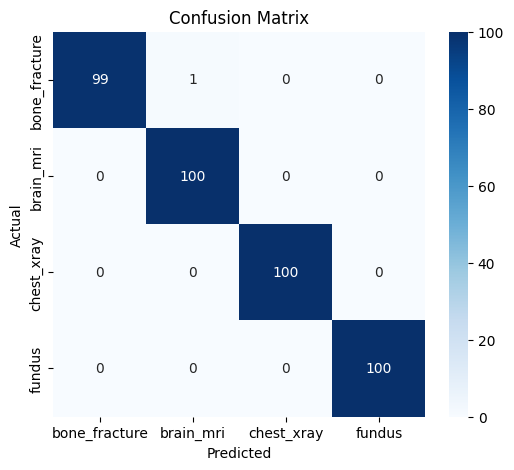

In [14]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ===== 1. Load best model =====
model.load_state_dict(torch.load("best_densenet_model.pth"))
model.eval()

# ===== 2. Inference on test set =====
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# ===== 3. Metrics =====
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save to your Google Drive path
save_path = "/content/drive/MyDrive/best_densenet_model.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Model saved to: {save_path}")